## Generate Static Graphs

These are the input parameters for the notebook. They will be automatically changed when the scripts to generate monthly statistics are run. You can modify them manually to generate multiple plots locally as well.

Pass in `None` to remove the filters and plot all data. This is not recommended for production settings, but might be useful for reports based on data snapshots.

In [1]:
year = None
month = None
program = "prepilot"
study_type = "program"
mode_of_interest = "pilot_ebike"

In [2]:
SAVE_DIR = '/plots/'

In [3]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model

import emission.core.get_database as edb
from plots import *
import scaffolding

sns.set_style("whitegrid")
sns.set()
%matplotlib inline

URL not formatted, defaulting to "Stage_database"
Connecting to database URL db


In [4]:
import plots
import importlib
importlib.reload(plots)

<module 'plots' from '/usr/src/app/saved-notebooks/plots.py'>

In [5]:
# Do not run this notebook at all unless it is for a program; nbclient will run up through this cell
if study_type != "program":
    raise Exception("The plots in this notebook are only relevant to programs")

In [6]:
# Loading mapping dictionaries from mapping_dictionaries notebook
%store -r df_ei
%store -r dic_re
%store -r dic_pur
%store -r dic_fuel

# convert a dictionary to a defaultdict
dic_re = defaultdict(lambda: 'Other',dic_re)
dic_pur = defaultdict(lambda: 'Other',dic_pur)
dic_fuel = defaultdict(lambda: 'Other',dic_fuel)

## Get UUIDs by Program

In [7]:
# Split UUIDs by program
program_uuid_map = {}
for ue in edb.get_uuid_db().find():
    program = ue['user_email'].split("_")[0]
    if program in program_uuid_map.keys():
        program_uuid_map[program].append(str(ue['uuid']))
    else:
        print(f"Found new program {program}, creating new list")
        program_uuid_map[program] = []
        program_uuid_map[program].append(str(ue['uuid']))

uuid_program_list = []
for ue in edb.get_uuid_db().find():
    program = ue['user_email'].split("_")[0]
    uuid_program_list.append({"program": program, "opcode": ue["user_email"], "user_id_str": str(ue['uuid'])})

Found new program 4c, creating new list
Found new program pc, creating new list
Found new program sc, creating new list
Found new program vail, creating new list
Found new program stage, creating new list
Found new program cc, creating new list
Found new program fc, creating new list


In [8]:
uuid_program_df = pd.DataFrame.from_dict(uuid_program_list)
uuid_program_df.head()

,program,opcode,user_id_str
0,4c,4c_Ze5Y_li7r4MOsbqj,863e9c6c-8ec0-48c4-b765-3f73d839c85b
1,4c,4c_AGgrHoywg5gYmyL8,c6e4db31-c18b-4355-b02a-7dd97deca70b
2,4c,4c_Ri332Xj3DKaCrdwl,c6807997-194c-4c52-8a8f-a8c1f6ee1595
3,4c,4c_6gzfgbVUODrbTdc_,e9e479e9-5c3f-4345-a885-dadb7999b312
4,4c,4c_eJEIg2mWQYU3ISXU,6656c04c-6cba-4c18-9fed-805eaa529741


## Collect Data From Database

In [9]:
expanded_ct, file_suffix, quality_text = scaffolding.load_viz_notebook_data(year,
                                                                            month,
                                                                            program,
                                                                            study_type,
                                                                            dic_re,
                                                                            dic_pur=dic_pur)
expanded_ct = scaffolding.add_energy_labels(expanded_ct, df_ei, dic_fuel)

0          4c_AGgrHoywg5gYmyL8
1          4c_Ri332Xj3DKaCrdwl
2          4c_6gzfgbVUODrbTdc_
3          4c_eJEIg2mWQYU3ISXU
4          4c_s7jHZr7a0yQOAa1b
                ...           
239    fc_csu_TMUSjqGBWELwW5mZ
240    fc_n2n__1f8tgZOmeizn0pJ
241    fc_n2n_xV9QUA9nMEVPYq1B
242    fc_csu_OZ_EXMB-w436dbCh
243    fc_n2n_gIVaKBYQtpjA7s5-
Name: user_email, Length: 244, dtype: object

Loaded all confirmed trips of length 135471


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_month,end_local_dt_day,end_local_dt_hour,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts
0,DwellSegmentationTimeFilter,1.626885e+09,2021-07-21T10:31:16-06:00,"{'type': 'Point', 'coordinates': [-107.8599774...",60f85d2453f7233da0b1a28c,1.626884e+09,2021-07-21T10:13:12.769000-06:00,"{'type': 'Point', 'coordinates': [-107.8579336...",1083.231000,9413.891182,...,7,21,10,31,16,2,America/Denver,612089e1cb13df1d4d22cfd9,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
1,DwellSegmentationTimeFilter,1.626920e+09,2021-07-21T20:05:41.808000-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",60f8dbb173697eb577aaff42,1.626918e+09,2021-07-21T19:38:56.389000-06:00,"{'type': 'Point', 'coordinates': [-107.7964539...",1605.419000,13124.152280,...,7,21,20,5,41,2,America/Denver,612089e1cb13df1d4d22cfda,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
2,DwellSegmentationTimeFilter,1.626971e+09,2021-07-22T10:15:32.259000-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",60f9aea3f399df93fdc1ab41,1.626969e+09,2021-07-22T09:51:21.159484-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",1451.099516,10587.088615,...,7,22,10,15,32,3,America/Denver,612089e1cb13df1d4d22cfdb,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
3,DwellSegmentationTimeFilter,1.626989e+09,2021-07-22T15:21:31-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",60f9f4f122abd49191e21f5c,1.626988e+09,2021-07-22T15:14:35.056996-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",415.943004,3362.028245,...,7,22,15,21,31,3,America/Denver,612089e1cb13df1d4d22cfdc,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
4,DwellSegmentationTimeFilter,1.626990e+09,2021-07-22T15:32:52.960000-06:00,"{'type': 'Point', 'coordinates': [-107.8601932...",60f9f4f122abd49191e21f5e,1.626989e+09,2021-07-22T15:24:53.289799-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",479.670201,4084.311560,...,7,22,15,32,52,3,America/Denver,612089e2cb13df1d4d22cfdd,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09


After filtering, found 134985 participant trips 


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_month,end_local_dt_day,end_local_dt_hour,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts
0,DwellSegmentationTimeFilter,1.626885e+09,2021-07-21T10:31:16-06:00,"{'type': 'Point', 'coordinates': [-107.8599774...",60f85d2453f7233da0b1a28c,1.626884e+09,2021-07-21T10:13:12.769000-06:00,"{'type': 'Point', 'coordinates': [-107.8579336...",1083.231000,9413.891182,...,7,21,10,31,16,2,America/Denver,612089e1cb13df1d4d22cfd9,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
1,DwellSegmentationTimeFilter,1.626920e+09,2021-07-21T20:05:41.808000-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",60f8dbb173697eb577aaff42,1.626918e+09,2021-07-21T19:38:56.389000-06:00,"{'type': 'Point', 'coordinates': [-107.7964539...",1605.419000,13124.152280,...,7,21,20,5,41,2,America/Denver,612089e1cb13df1d4d22cfda,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
2,DwellSegmentationTimeFilter,1.626971e+09,2021-07-22T10:15:32.259000-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",60f9aea3f399df93fdc1ab41,1.626969e+09,2021-07-22T09:51:21.159484-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",1451.099516,10587.088615,...,7,22,10,15,32,3,America/Denver,612089e1cb13df1d4d22cfdb,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
3,DwellSegmentationTimeFilter,1.626989e+09,2021-07-22T15:21:31-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",60f9f4f122abd49191e21f5c,1.626988e+09,2021-07-22T15:14:35.056996-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",415.943004,3362.028245,...,7,22,15,21,31,3,America/Denver,612089e1cb13df1d4d22cfdc,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
4,DwellSegmentationTimeFilter,1.626990e+09,2021-07-22T15:32:52.960000-06:00,"{'type': 'Point', 'coordinates': [-107.8601932...",60f9f4f122abd49191e21f5e,1.626989e+09,2021-07-22T15:24:53.289799-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",479.670201,4084.311560,...,7,22,15,32,52,3,America/Denver,612089e2cb13df1d4d22cfdd,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09


After filtering, found 49952 labeled trips


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_day,end_local_dt_hour,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts,user_id_str
0,DwellSegmentationTimeFilter,1.626885e+09,2021-07-21T10:31:16-06:00,"{'type': 'Point', 'coordinates': [-107.8599774...",60f85d2453f7233da0b1a28c,1.626884e+09,2021-07-21T10:13:12.769000-06:00,"{'type': 'Point', 'coordinates': [-107.8579336...",1083.231000,9413.891182,...,21,10,31,16,2,America/Denver,612089e1cb13df1d4d22cfd9,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312
1,DwellSegmentationTimeFilter,1.626920e+09,2021-07-21T20:05:41.808000-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",60f8dbb173697eb577aaff42,1.626918e+09,2021-07-21T19:38:56.389000-06:00,"{'type': 'Point', 'coordinates': [-107.7964539...",1605.419000,13124.152280,...,21,20,5,41,2,America/Denver,612089e1cb13df1d4d22cfda,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312
2,DwellSegmentationTimeFilter,1.626971e+09,2021-07-22T10:15:32.259000-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",60f9aea3f399df93fdc1ab41,1.626969e+09,2021-07-22T09:51:21.159484-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",1451.099516,10587.088615,...,22,10,15,32,3,America/Denver,612089e1cb13df1d4d22cfdb,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312
3,DwellSegmentationTimeFilter,1.626989e+09,2021-07-22T15:21:31-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",60f9f4f122abd49191e21f5c,1.626988e+09,2021-07-22T15:14:35.056996-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",415.943004,3362.028245,...,22,15,21,31,3,America/Denver,612089e1cb13df1d4d22cfdc,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312
4,DwellSegmentationTimeFilter,1.626990e+09,2021-07-22T15:32:52.960000-06:00,"{'type': 'Point', 'coordinates': [-107.8601932...",60f9f4f122abd49191e21f5e,1.626989e+09,2021-07-22T15:24:53.289799-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",479.670201,4084.311560,...,22,15,32,52,3,America/Denver,612089e2cb13df1d4d22cfdd,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312


,mode_confirm,purpose_confirm,replaced_mode
0,drove_alone,work,NaN
1,drove_alone,home,NaN
2,drove_alone,work,NaN
3,drove_alone,meal,NaN
4,drove_alone,meal,NaN


After expanding, columns went from 39 -> 42


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts,user_id_str,mode_confirm,purpose_confirm,replaced_mode
0,DwellSegmentationTimeFilter,1.626885e+09,2021-07-21T10:31:16-06:00,"{'type': 'Point', 'coordinates': [-107.8599774...",60f85d2453f7233da0b1a28c,1.626884e+09,2021-07-21T10:13:12.769000-06:00,"{'type': 'Point', 'coordinates': [-107.8579336...",1083.231000,9413.891182,...,16,2,America/Denver,612089e1cb13df1d4d22cfd9,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312,drove_alone,work,NaN
1,DwellSegmentationTimeFilter,1.626920e+09,2021-07-21T20:05:41.808000-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",60f8dbb173697eb577aaff42,1.626918e+09,2021-07-21T19:38:56.389000-06:00,"{'type': 'Point', 'coordinates': [-107.7964539...",1605.419000,13124.152280,...,41,2,America/Denver,612089e1cb13df1d4d22cfda,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312,drove_alone,home,NaN
2,DwellSegmentationTimeFilter,1.626971e+09,2021-07-22T10:15:32.259000-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",60f9aea3f399df93fdc1ab41,1.626969e+09,2021-07-22T09:51:21.159484-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",1451.099516,10587.088615,...,32,3,America/Denver,612089e1cb13df1d4d22cfdb,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312,drove_alone,work,NaN
3,DwellSegmentationTimeFilter,1.626989e+09,2021-07-22T15:21:31-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",60f9f4f122abd49191e21f5c,1.626988e+09,2021-07-22T15:14:35.056996-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",415.943004,3362.028245,...,31,3,America/Denver,612089e1cb13df1d4d22cfdc,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312,drove_alone,meal,NaN
4,DwellSegmentationTimeFilter,1.626990e+09,2021-07-22T15:32:52.960000-06:00,"{'type': 'Point', 'coordinates': [-107.8601932...",60f9f4f122abd49191e21f5e,1.626989e+09,2021-07-22T15:24:53.289799-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",479.670201,4084.311560,...,52,3,America/Denver,612089e2cb13df1d4d22cfdd,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312,drove_alone,meal,NaN


_fc
Based on 49952 confirmed trips from 145 users
of 111164 total trips from 148 users (44.94%)


In [10]:
file_suffix = '_prepilot'

In [11]:
# Join to the program df to get each user's program
expanded_ct = expanded_ct.merge(uuid_program_df, on='user_id_str')

In [12]:
# Join the expanded database data to socioeconomic data
socio_data = pd.read_csv('./Can Do Colorado eBike Program - en.csv')
socio_data.rename(columns={'Unique User ID (auto-filled, do not edit)':'user_id',
                          'Please identify which category represents your total household income, before taxes, for last year.':'HHINC',
                          'How many motor vehicles are owned, leased, or available for regular use by the people who currently live in your household?':'VEH',
                           'In which year were you born?':'AGE',
                          'Including yourself, how many people live in your home?':'HHSIZE',
                          'How many children under age 18 live in your home?':'CHILDREN',
                          'What is your gender?':'GENDER',
                          'If you were unable to use your household vehicle(s), which of the following options would be available to you to get you from place to place?':'available_modes',
                          'Are you a student?':'STUDENT'}, inplace=True)
socio_data = socio_data[~socio_data.user_id.isnull()]

# Deal with people who have multiple responses by using most recent
socio_data = socio_data.sort_values(by=['user_id', 'Timestamp'])
socio_data.drop_duplicates(subset=['user_id'], keep='last', inplace=True)
socio_data['user_id_socio'] = socio_data.user_id
socio_data = socio_data.drop(labels='user_id', axis=1)

# Lose some trips due to people with no survey responses
expanded_ct['user_id_socio'] = expanded_ct.user_id.astype(str)
expanded_ct.user_id_socio = [i.replace('-','') for i in expanded_ct.user_id_socio] # remove all dashes from strings
expanded_ct = expanded_ct.merge(socio_data, on='user_id_socio')

In [13]:
data = expanded_ct.copy()

# # Add non-label category
# expanded_ct['replaced_mode'] = expanded_ct['replaced_mode'].fillna('Unlabeled')
# expanded_ct.loc[expanded_ct['replaced_mode'] == 'Unlabeled', 'Replaced_mode'] = "Unlabeled"

# # List of variables to keep in data but not turn into categorical number variables
# dont_categorize = ['user_id','_id','cleaned_trip']

# # Make copy of user_id to be categorized since both versions are needed
# data['user_id_int'] = data['user_id']

# Get timestamp from known year/month/day aggregated to days
data.rename(columns={'start_local_dt_year':'year','start_local_dt_month':'month','start_local_dt_day':'day'}, inplace=True)
data['date_time'] = pd.to_datetime(data[['year','month','day']])

# Fix age
data['AGE'] = 2022 - data['AGE']

# Number of workers
data['WORKERS'] = data['HHSIZE'] - data['CHILDREN']

# Duration in minutes
data['duration'] = data['duration'] / 60

# E-bike/not E-Bike variable
data['is_ebike'] = "E-Bike Trips"
data.loc[data['Mode_confirm']!="E-bike", 'is_ebike'] = "Non E-Bike Trips"

data = data[~data['HHINC'].isin(['Prefer not to say', '$150,000'])] # Side note why is 150k (n=7) its own bin?
data['HHINC_NUM'] = data.HHINC.replace(['Less than $24,999',
                                       '$25,000-$49,999',
                                       '$50,000-$99,999',
                                       '$100,000 -$149,999',
                                       '$150,000-$199,999',
                                       '$200,000 or more'], [12500,37500,75000,125000,175000,250000])

# Calculate average income per adult in the household
data['PINC'] = data['HHINC_NUM'] / data['WORKERS']

# Combine variable categories
data = data.replace('Gas Car, drove alone', 'Car')
data = data.replace('Gas Car, with others', 'Shared Car')
data = data.replace('Bikeshare', 'Shared Micromobility')
data = data.replace('Scooter share', 'Shared Micromobility')
data = data.replace('Regular Bike', 'Personal Micromobility')
data = data.replace('Skate board', 'Personal Micromobility')
data = data.replace('Train', 'Transit')
data = data.replace('Free Shuttle', 'Transit')
data = data.replace('Bus', 'Transit')
data = data.replace('Walk', 'Walk')
data = data.replace('Taxi/Uber/Lyft', 'Ridehail')
data = data.replace('Pilot ebike', 'E-Bike')

# Categorical type will include all days/modes in groupby even if there is no data for a particular tabulation
data.user_id = pd.Categorical(data.user_id)
data.date_time = pd.Categorical(data.date_time)
data.mode_confirm = pd.Categorical(data.mode_confirm, ordered=True, categories=np.unique(list(dic_re.keys())))

# Add order to categorical variables
data.HHINC = pd.Categorical(data.HHINC, ordered=True, categories=['Less than $24,999',
                                                                 '$25,000-$49,999',
                                                                 '$50,000-$99,999'])
data['Mode'] = pd.Categorical(data.Mode_confirm, ordered=True, categories=[
    'E-bike',
    'Car',
    'Shared Car',
    'Walk',
    'Transit',
    'Personal Micromobility',
    'Shared Micromobility',
    'Ridehail',
    'Other'])
data.VEH = pd.Categorical(data.VEH, ordered=True, categories=['0','1','2','3','4+'])
data['PINC_NUM'] = data['PINC']
data.PINC = pd.cut(data.PINC, bins=[0,10000,20000,30000,40000,50000,60000,70000,999999],
                  labels=["$0-9",
                         "$10-19",
                         "$20-29",
                         "$30-39",
                         "$40-49",
                         "$50-59",
                         "$60-69",
                         "$70+"])

# Vehicles per driver
data['VEH_num'] = data['VEH'].replace(['1','2','3','4+'],[1,2,3,4]).astype(int)
data['DRIVERS'] = data["Including yourself, how many people have a driver's license in your household?"]
data['DRIVERS_num'] = data['DRIVERS'].replace
data['veh_per_driver'] = (data['VEH_num'] / data['DRIVERS']).fillna(0)
data.loc[data['veh_per_driver']==np.inf, 'veh_per_driver'] = 0

In [14]:
# Data Filtering
print(len(data))
data = data[data['AGE']<100]
data = data[data['distance_miles']<50]
data = data[data['duration']<480]
data = data[~data['Mode_confirm'].isin(['Not a Trip'])]
data = data[~data['Replaced_mode'].isin(['Not a Trip'])]
data = data[~data['HHINC'].isin(['Prefer not to say','$100,000 -$149,999','$150,000','$150,000-$199,999','$200,000 or more'])] # Side note why is 150k (n=7) its own bin?
data = data[~data['VEH'].isin(['Prefer not to say / Prefiero no decir.'])]
data = data[~data['Trip_purpose'].isin(['not_a_trip'])]
data = data[~data['available_modes'].isin(['None', 'Prefer not to say'])]
data = data[data['HHSIZE']<10]
data = data[data['HHSIZE']>data['CHILDREN']]
print(len(data))

44458
41744


## Data Overview

In [15]:
data_eb = data.query(f"mode_confirm == '{mode_of_interest}'")

In [16]:
data.columns

Index(['source', 'end_ts', 'end_fmt_time', 'end_loc', 'raw_trip', 'start_ts',
       'start_fmt_time', 'start_loc', 'duration', 'distance', 'start_place',
       'end_place', 'cleaned_trip', 'inferred_labels', 'inferred_trip',
       'expectation', 'confidence_threshold', 'expected_trip', 'user_input',
       'year', 'month', 'day', 'start_local_dt_hour', 'start_local_dt_minute',
       'start_local_dt_second', 'start_local_dt_weekday',
       'start_local_dt_timezone', 'end_local_dt_year', 'end_local_dt_month',
       'end_local_dt_day', 'end_local_dt_hour', 'end_local_dt_minute',
       'end_local_dt_second', 'end_local_dt_weekday', 'end_local_dt_timezone',
       '_id', 'user_id', 'metadata_write_ts', 'user_id_str', 'mode_confirm',
       'purpose_confirm', 'replaced_mode', 'distance_miles', 'Mode_confirm',
       'Replaced_mode', 'Trip_purpose', 'Mode_confirm_fuel',
       'Replaced_mode_fuel', 'ei_Replaced_mode', 'CO2_Replaced_mode',
       'ei_trip_Replaced_mode', 'ei_Mode_confir

In [17]:
# Summary statistics table
print(len(pd.unique(data.user_id)))
stat_data = data[['distance_miles','duration']]
stat_data.describe()

125


,distance_miles,duration
count,41744.000000,41744.000000
mean,4.021620,24.856155
std,5.939448,32.381894
min,0.062156,0.000068
25%,0.784315,9.520730
50%,2.067866,15.507022
75%,4.530765,28.657178
max,49.896797,479.495935


## Figures

### Program Participation

In [18]:
# Access database
tq = scaffolding.get_time_query(year, month)
participant_ct_df = scaffolding.load_all_participant_trips(program, tq)
participant_ct_df["user_id_str"] = participant_ct_df.user_id.apply(lambda u: str(u))
# Remove stage users
stage_uuids = scaffolding.get_stage_ids()
non_stage_ct_df = participant_ct_df[~participant_ct_df['user_id_str'].isin(stage_uuids)]

0          4c_AGgrHoywg5gYmyL8
1          4c_Ri332Xj3DKaCrdwl
2          4c_6gzfgbVUODrbTdc_
3          4c_eJEIg2mWQYU3ISXU
4          4c_s7jHZr7a0yQOAa1b
                ...           
239    fc_csu_TMUSjqGBWELwW5mZ
240    fc_n2n__1f8tgZOmeizn0pJ
241    fc_n2n_xV9QUA9nMEVPYq1B
242    fc_csu_OZ_EXMB-w436dbCh
243    fc_n2n_gIVaKBYQtpjA7s5-
Name: user_email, Length: 244, dtype: object

Loaded all confirmed trips of length 135471


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_month,end_local_dt_day,end_local_dt_hour,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts
0,DwellSegmentationTimeFilter,1.626885e+09,2021-07-21T10:31:16-06:00,"{'type': 'Point', 'coordinates': [-107.8599774...",60f85d2453f7233da0b1a28c,1.626884e+09,2021-07-21T10:13:12.769000-06:00,"{'type': 'Point', 'coordinates': [-107.8579336...",1083.231000,9413.891182,...,7,21,10,31,16,2,America/Denver,612089e1cb13df1d4d22cfd9,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
1,DwellSegmentationTimeFilter,1.626920e+09,2021-07-21T20:05:41.808000-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",60f8dbb173697eb577aaff42,1.626918e+09,2021-07-21T19:38:56.389000-06:00,"{'type': 'Point', 'coordinates': [-107.7964539...",1605.419000,13124.152280,...,7,21,20,5,41,2,America/Denver,612089e1cb13df1d4d22cfda,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
2,DwellSegmentationTimeFilter,1.626971e+09,2021-07-22T10:15:32.259000-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",60f9aea3f399df93fdc1ab41,1.626969e+09,2021-07-22T09:51:21.159484-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",1451.099516,10587.088615,...,7,22,10,15,32,3,America/Denver,612089e1cb13df1d4d22cfdb,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
3,DwellSegmentationTimeFilter,1.626989e+09,2021-07-22T15:21:31-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",60f9f4f122abd49191e21f5c,1.626988e+09,2021-07-22T15:14:35.056996-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",415.943004,3362.028245,...,7,22,15,21,31,3,America/Denver,612089e1cb13df1d4d22cfdc,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
4,DwellSegmentationTimeFilter,1.626990e+09,2021-07-22T15:32:52.960000-06:00,"{'type': 'Point', 'coordinates': [-107.8601932...",60f9f4f122abd49191e21f5e,1.626989e+09,2021-07-22T15:24:53.289799-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",479.670201,4084.311560,...,7,22,15,32,52,3,America/Denver,612089e2cb13df1d4d22cfdd,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09


After filtering, found 134985 participant trips 


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_month,end_local_dt_day,end_local_dt_hour,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts
0,DwellSegmentationTimeFilter,1.626885e+09,2021-07-21T10:31:16-06:00,"{'type': 'Point', 'coordinates': [-107.8599774...",60f85d2453f7233da0b1a28c,1.626884e+09,2021-07-21T10:13:12.769000-06:00,"{'type': 'Point', 'coordinates': [-107.8579336...",1083.231000,9413.891182,...,7,21,10,31,16,2,America/Denver,612089e1cb13df1d4d22cfd9,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
1,DwellSegmentationTimeFilter,1.626920e+09,2021-07-21T20:05:41.808000-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",60f8dbb173697eb577aaff42,1.626918e+09,2021-07-21T19:38:56.389000-06:00,"{'type': 'Point', 'coordinates': [-107.7964539...",1605.419000,13124.152280,...,7,21,20,5,41,2,America/Denver,612089e1cb13df1d4d22cfda,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
2,DwellSegmentationTimeFilter,1.626971e+09,2021-07-22T10:15:32.259000-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",60f9aea3f399df93fdc1ab41,1.626969e+09,2021-07-22T09:51:21.159484-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",1451.099516,10587.088615,...,7,22,10,15,32,3,America/Denver,612089e1cb13df1d4d22cfdb,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
3,DwellSegmentationTimeFilter,1.626989e+09,2021-07-22T15:21:31-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",60f9f4f122abd49191e21f5c,1.626988e+09,2021-07-22T15:14:35.056996-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",415.943004,3362.028245,...,7,22,15,21,31,3,America/Denver,612089e1cb13df1d4d22cfdc,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
4,DwellSegmentationTimeFilter,1.626990e+09,2021-07-22T15:32:52.960000-06:00,"{'type': 'Point', 'coordinates': [-107.8601932...",60f9f4f122abd49191e21f5e,1.626989e+09,2021-07-22T15:24:53.289799-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",479.670201,4084.311560,...,7,22,15,32,52,3,America/Denver,612089e2cb13df1d4d22cfdd,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09


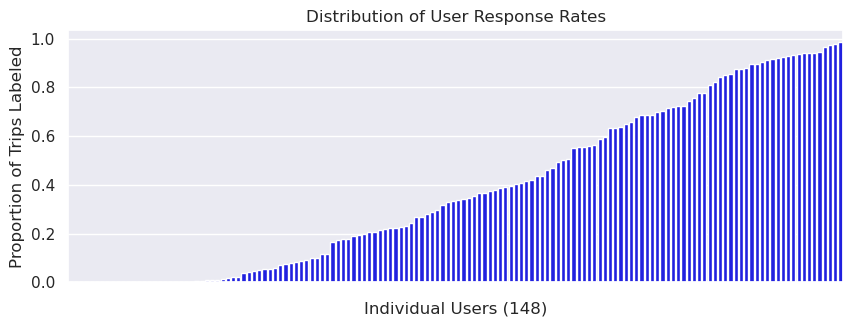

In [19]:
# Proportion of trips labeled by user
all_user_trips = non_stage_ct_df.groupby(['user_id'], as_index=False).count()[['user_id','distance']]
labeled_user_trips = data.groupby(['user_id'], as_index=False).count()[['user_id','distance']]
plot_data = all_user_trips.merge(labeled_user_trips, how='left', on='user_id').fillna(0)
plot_data['proportion'] = plot_data['distance_y'] / plot_data['distance_x']
data_order = plot_data.sort_values('proportion', ascending=True).user_id

plot_title='Distribution of User Response Rates'
ylab='Proportion of Trips Labeled'
file_name='CanBikeCO_report_user_participation%s'%file_suffix
fig, ax = plt.subplots(figsize=(10,4))
sns.barplot(data=plot_data, x='user_id', y='proportion', order=data_order, color='blue').set(title=plot_title,xlabel='Individual Users (148)',ylabel=ylab,xticklabels=[])
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig(SAVE_DIR+file_name+".png", bbox_inches='tight')

### Updates to the Pilot Study

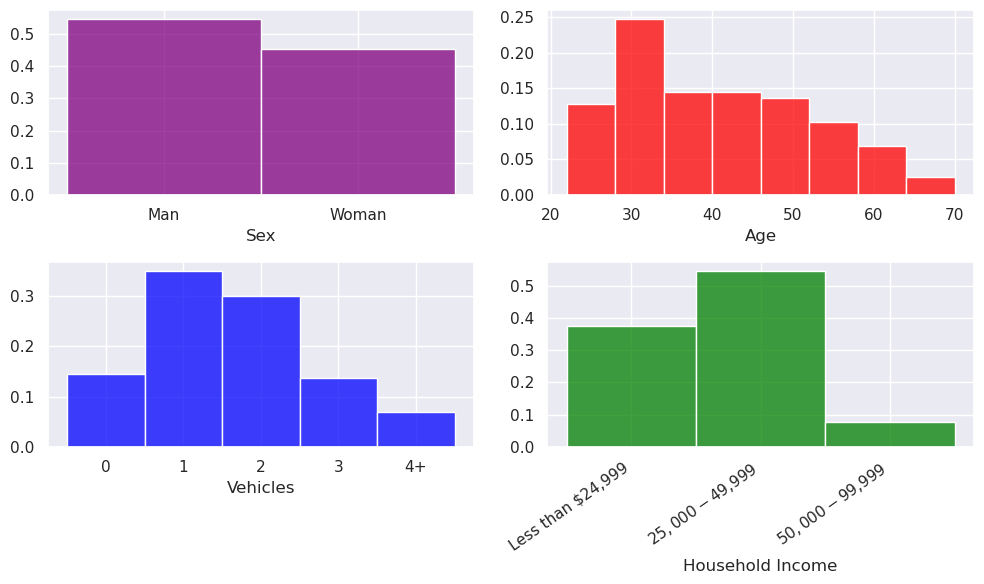

In [20]:
# Age, Income, Gender
plot_data = data.copy()
plot_data = plot_data.groupby(['user_id']).nth(0)[['AGE','GENDER','VEH','HHINC']].dropna()
plot_data = plot_data[plot_data['GENDER'].isin(['Man','Woman'])]
plot_data = plot_data.groupby(['user_id'], as_index=False).nth(0)

plot_title='Participant Demographics'
ylab='Count'
file_name='CanBikeCO_report_demog%s'%file_suffix

fig, axs = plt.subplots(2,2,figsize=(10,6))
sns.histplot(data=plot_data, x='GENDER', ax=axs[0,0], color='purple', stat='probability').set(xlabel='Sex',ylabel='')
sns.histplot(data=plot_data, x='AGE', ax=axs[0,1], color='red', stat='probability').set(xlabel='Age',ylabel='')
sns.histplot(data=plot_data, x='VEH', ax=axs[1,0], color='blue', stat='probability').set(xlabel='Vehicles',ylabel='')
sns.histplot(data=pd.DataFrame(plot_data['HHINC'].dropna()), x='HHINC', ax=axs[1,1], color='green', stat='probability').set(xlabel='Household Income',ylabel='')
plt.xticks(rotation=35, ha='right')
plt.tight_layout()

fig.savefig(SAVE_DIR+file_name+".png", bbox_inches='tight')

In [21]:
sns.set_palette('tab20', 9)

In [22]:
minipilot_mode_labels = ['Car',
                   'Shared Car',
                   'Walk',
                   'Transit',
                   'Ridehail',
                   'Other',
                   'E-bike']
minipilot_all_data = [.293,
                     .209,
                     .075,
                     .054,
                     .029,
                     .029,
                     .313]
minipilot_commute_data = [.270,
                         .294,
                         .050,
                         .0,
                         .0,
                         .062,
                         .324]
colnames = ['Mode_confirm','All Trips','Commute Trips']
minipilot_mode_data_1 = pd.DataFrame(list(zip(minipilot_mode_labels, minipilot_all_data)))
minipilot_mode_data_2 = pd.DataFrame(list(zip(minipilot_mode_labels, minipilot_commute_data)))
minipilot_mode_data_1['Trip Type'] = 'All Trips'
minipilot_mode_data_2['Trip Type'] = 'Work Trips'
minipilot_mode_data = pd.concat([minipilot_mode_data_1, minipilot_mode_data_2])
minipilot_mode_data['Dataset'] = 'Minipilot'
minipilot_mode_data.columns = ['Mode','Proportion','Trip Type','Dataset']

minipilot_purp_labels = ['Home',
                   'Work',
                   'Pick-up/Drop off',
                   'Shopping',
                   'Recreation/Exercise',
                   'Meal',
                   'Entertainment/Social',
                   'Transit transfer',
                   'Other',
                   'Personal/Medical']
minipilot_all_data = [.171,
                     .163,
                     .138,
                     .120,
                     .058,
                     .055,
                     .045,
                     .022,
                     .051,
                     .176]
minipilot_commute_data = [.162,
                         .166,
                         .190,
                         .097,
                         .086,
                         .082,
                         .061,
                          0,
                         .052,
                         .104]
colnames = ['Trip_purpose','All Trips','E-Bike Trips']
minipilot_purp_data_1 = pd.DataFrame(list(zip(minipilot_purp_labels, minipilot_all_data)))
minipilot_purp_data_2 = pd.DataFrame(list(zip(minipilot_purp_labels, minipilot_commute_data)))
minipilot_purp_data_1['Trip Type'] = 'All Trips'
minipilot_purp_data_2['Trip Type'] = 'E-Bike Trips'
minipilot_purp_data = pd.concat([minipilot_purp_data_1, minipilot_purp_data_2])
minipilot_purp_data['Dataset'] = 'Minipilot'
minipilot_purp_data.columns = ['Purpose','Proportion','Trip Type','Dataset']

In [23]:
plot_data = data.copy()
plot_data.loc[plot_data['Mode_confirm']=='Personal Micromobility', 'Mode_confirm'] = 'Other'
plot_data.loc[plot_data['Mode_confirm']=='Shared Micromobility', 'Mode_confirm'] = 'Other'
t1 = plot_data.groupby(['Mode_confirm'], as_index=False).count()[['Mode_confirm','distance_miles']]
t1['proportion'] = t1['distance_miles'] / np.sum(t1.distance_miles)
t1['distance_miles'] = 'All Trips'

t2 = plot_data[plot_data['Trip_purpose']=='Work'].copy()
t2 = t2.groupby(['Mode_confirm'], as_index=False).count()[['Mode_confirm','distance_miles']]
t2['proportion'] = t2['distance_miles'] / np.sum(t2.distance_miles)
t2['distance_miles'] = 'Work Trips'

plot_data = pd.concat([t1,t2])
plot_data['Dataset'] = 'Long Term'
plot_data.columns = ['Mode','Trip Type','Proportion','Dataset']
plot_data = pd.concat([plot_data, minipilot_mode_data])

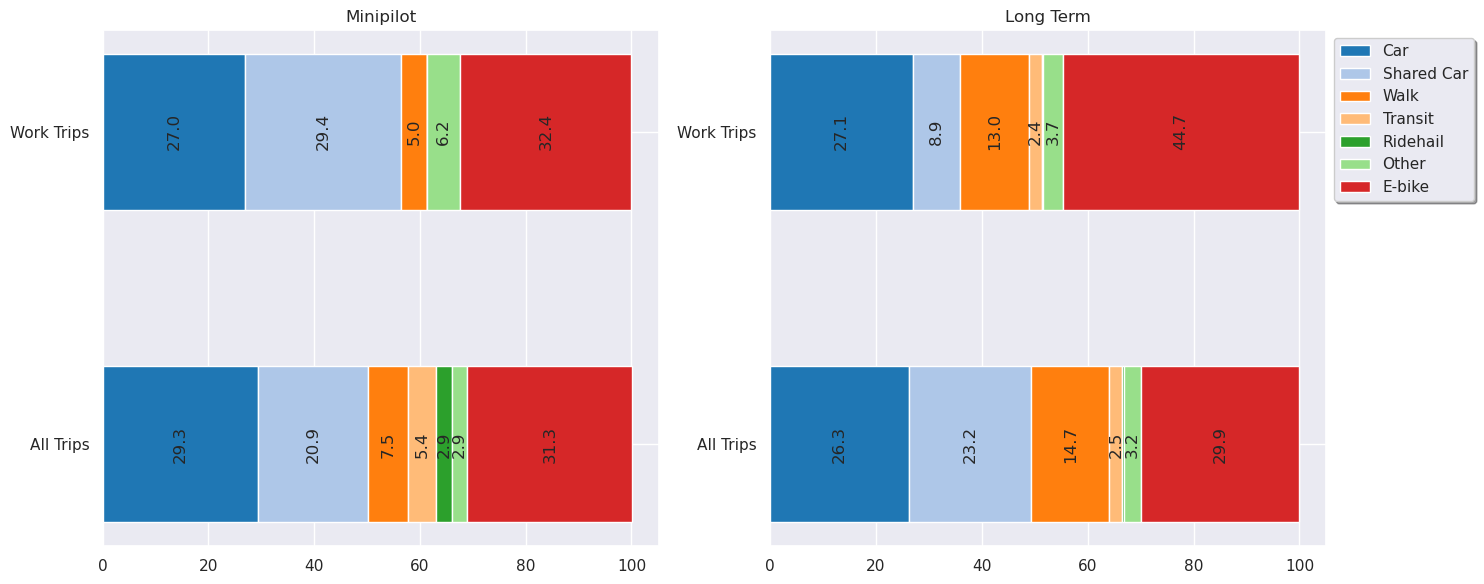

In [24]:
width = 0.5
fig, ax = plt.subplots(1,2, figsize=(15,6))
running_total_mini = [0,0]
running_total_long = [0,0]
fig_data_mini = plot_data[plot_data['Dataset']=='Minipilot']
fig_data_long = plot_data[plot_data['Dataset']=='Long Term']

for mode in pd.unique(fig_data_mini.Mode):
    mini = fig_data_mini[fig_data_mini['Mode']==mode]
    long = fig_data_long[fig_data_long['Mode']==mode]

    labels = mini['Trip Type']
    vals = mini['Proportion']*100
    vals_str = [round(v,1) if v>1 else '' for v in vals]
    bar = ax[0].barh(labels, vals, width, left=running_total_mini, label=mode)
    ax[0].bar_label(bar, label_type='center', labels=vals_str, rotation=90)
    running_total_mini[0] = running_total_mini[0]+vals.iloc[0]
    running_total_mini[1] = running_total_mini[1]+vals.iloc[1]

    labels = long['Trip Type']
    vals = long['Proportion']*100
    vals_str = [round(v,1) if v>1 else '' for v in vals]
    bar = ax[1].barh(labels, vals, width, left=running_total_long, label=mode)
    ax[1].bar_label(bar, label_type='center', labels=vals_str, rotation=90)
    running_total_long[0] = running_total_long[0]+vals.iloc[0]
    running_total_long[1] = running_total_long[1]+vals.iloc[1]

file_name='CanBikeCO_report_mode_share%s'%file_suffix
ax[0].set_title('Minipilot')
ax[1].set_title('Long Term')
ax[1].legend(bbox_to_anchor=(1,1), fancybox=True, shadow=True)
plt.subplots_adjust(bottom=0.25)
fig.tight_layout()
plt.show()
fig.savefig(SAVE_DIR+file_name+".png", bbox_inches='tight')

In [25]:
# # Mode share for all trips
# plot_data = data.copy()
# t1 = plot_data.groupby(['user_id','Mode_confirm'], as_index=False).count()[['user_id','Mode_confirm','distance_miles']]
# t1['distance_miles'].fillna(0, inplace=True)
# t2 = plot_data.groupby(['user_id'], as_index=False).count()[['user_id','distance_miles']]
# plot_data = t1.merge(t2, on='user_id')
# plot_data['proportion'] = plot_data['distance_miles_x'] / plot_data['distance_miles_y']
# plot_data['proportion'].fillna(0, inplace=True)

# data_order = plot_data.groupby(['Mode_confirm'], as_index=False).mean().sort_values('proportion', ascending=False).Mode_confirm
# labels = plot_data.groupby(['Mode_confirm'], as_index=False).mean().sort_values('proportion', ascending=False).proportion

# plot_title='Mode Share of All Trips'
# ylab='Proportion of Trips'
# file_name='CanBikeCO_report_mode_share%s'%file_suffix
# fig, ax = plt.subplots(figsize=(10,4))
# sns.barplot(data=plot_data, x='Mode_confirm', y='proportion', estimator=np.mean, order=data_order).set(title=plot_title,xlabel='',ylabel=ylab,ylim=(0,.5))
# plt.xticks(rotation=35, ha='right')
# plt.subplots_adjust(bottom=0.25)
# ax.bar_label(ax.containers[0], fmt='%.2f', padding=30)
# ax.figure.savefig(SAVE_DIR+file_name+".png", bbox_inches='tight')

In [26]:
# # Mode share for commute trips
# plot_data = data.copy()
# plot_data = plot_data[plot_data['Trip_purpose']=='Work']
# t1 = plot_data.groupby(['user_id','Mode_confirm'], as_index=False).count()[['user_id','Mode_confirm','distance_miles']]
# t1['distance_miles'].fillna(0, inplace=True)
# t2 = plot_data.groupby(['user_id'], as_index=False).count()[['user_id','distance_miles']]
# plot_data = t1.merge(t2, on='user_id')
# plot_data['proportion'] = plot_data['distance_miles_x'] / plot_data['distance_miles_y']
# plot_data['proportion'].fillna(0, inplace=True)

# plot_title='Mode Share of Commute Trips'
# ylab='Proportion of Trips'
# file_name='CanBikeCO_report_mode_share_commute%s'%file_suffix
# fig, ax = plt.subplots(figsize=(10,4))
# sns.barplot(data=plot_data, x='Mode_confirm', y='proportion', estimator=np.mean, order=data_order).set(title=plot_title,xlabel='',ylabel=ylab,ylim=(0,.5))
# plt.xticks(rotation=35, ha='right')
# plt.subplots_adjust(bottom=0.25)
# ax.bar_label(ax.containers[0], fmt='%.2f', padding=30)
# ax.figure.savefig(SAVE_DIR+file_name+".png", bbox_inches='tight')

In [27]:
sns.set_palette('tab20', 12)

In [28]:
plot_data = data.copy()
plot_data.loc[plot_data['Trip_purpose']=='Religious', 'Trip_purpose'] = 'Other'
plot_data.loc[plot_data['Trip_purpose']=='School', 'Trip_purpose'] = 'Other'
t1 = plot_data.groupby(['Trip_purpose'], as_index=False).count()[['Trip_purpose','distance_miles']]
t1['proportion'] = t1['distance_miles'] / np.sum(t1.distance_miles)
t1['distance_miles'] = 'All Trips'

t2 = plot_data[plot_data['Mode_confirm']=='E-bike'].copy()
t2 = t2.groupby(['Trip_purpose'], as_index=False).count()[['Trip_purpose','distance_miles']]
t2['proportion'] = t2['distance_miles'] / np.sum(t2.distance_miles)
t2['distance_miles'] = 'E-Bike Trips'

plot_data = pd.concat([t1,t2])
plot_data['Dataset'] = 'Long Term'
plot_data.columns = ['Purpose','Trip Type','Proportion','Dataset']
plot_data = pd.concat([plot_data, minipilot_purp_data])

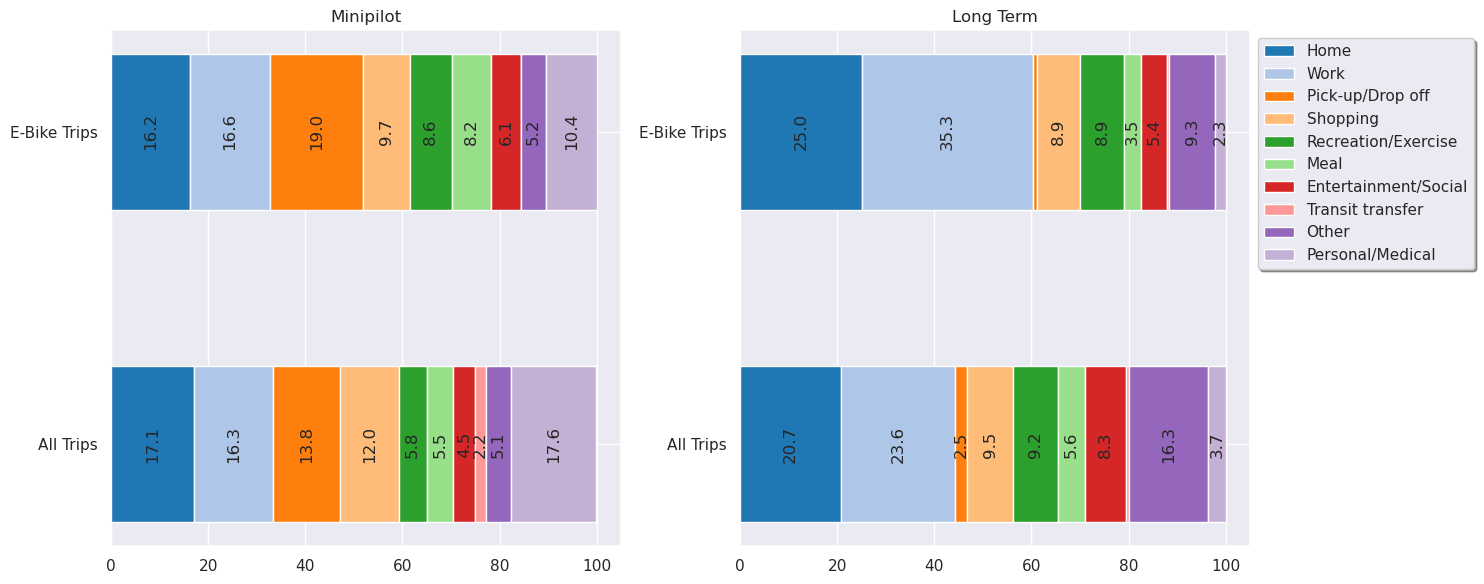

In [29]:
width = 0.5
fig, ax = plt.subplots(1,2, figsize=(15,6))
running_total_mini = [0,0]
running_total_long = [0,0]
fig_data_mini = plot_data[plot_data['Dataset']=='Minipilot']
fig_data_long = plot_data[plot_data['Dataset']=='Long Term']

for purp in pd.unique(fig_data_mini.Purpose):
    mini = fig_data_mini[fig_data_mini['Purpose']==purp]
    long = fig_data_long[fig_data_long['Purpose']==purp]

    labels = mini['Trip Type']
    vals = mini['Proportion']*100
    vals_str = [round(v,1) if v>1 else '' for v in vals]
    bar = ax[0].barh(labels, vals, width, left=running_total_mini, label=purp)
    ax[0].bar_label(bar, label_type='center', labels=vals_str, rotation=90)
    running_total_mini[0] = running_total_mini[0]+vals.iloc[0]
    running_total_mini[1] = running_total_mini[1]+vals.iloc[1]

    labels = long['Trip Type']
    vals = long['Proportion']*100
    vals_str = [round(v,1) if v>1 else '' for v in vals]
    bar = ax[1].barh(labels, vals, width, left=running_total_long, label=purp)
    ax[1].bar_label(bar, label_type='center', labels=vals_str, rotation=90)
    running_total_long[0] = running_total_long[0]+vals.iloc[0]
    running_total_long[1] = running_total_long[1]+vals.iloc[1]

file_name='CanBikeCO_report_purp_share%s'%file_suffix
ax[0].set_title('Minipilot')
ax[1].set_title('Long Term')
ax[1].legend(bbox_to_anchor=(1,1), fancybox=True, shadow=True)
plt.subplots_adjust(bottom=0.25)
fig.tight_layout()
plt.show()
fig.savefig(SAVE_DIR+file_name+".png", bbox_inches='tight')

In [30]:
# # Trip purpose for all trips
# plot_data = data.copy()
# t1 = plot_data.groupby(['user_id','Trip_purpose'], as_index=False).count()[['user_id','Trip_purpose','distance_miles']]
# t1['distance_miles'].fillna(0, inplace=True)
# t2 = plot_data.groupby(['user_id'], as_index=False).count()[['user_id','distance_miles']]
# plot_data = t1.merge(t2, on='user_id')
# plot_data['proportion'] = plot_data['distance_miles_x'] / plot_data['distance_miles_y']
# plot_data['proportion'].fillna(0, inplace=True)

# data_order = plot_data.groupby(['Trip_purpose'], as_index=False).mean().sort_values('proportion', ascending=False).Trip_purpose
# labels = plot_data.groupby(['Trip_purpose'], as_index=False).mean().sort_values('proportion', ascending=False).Trip_purpose

# plot_title='Trip Purpose for All Trips'
# ylab='Proportion of Total Trips'
# file_name='CanBikeCO_report_purp_share%s'%file_suffix
# fig, ax = plt.subplots(figsize=(10,4))
# sns.barplot(data=plot_data, x='Trip_purpose', y='proportion', estimator=np.mean, order=data_order).set(title=plot_title,xlabel='',ylabel=ylab,ylim=(0,.5))
# plt.xticks(rotation=35, ha='right')
# plt.subplots_adjust(bottom=0.25)
# ax.bar_label(ax.containers[0], fmt='%.2f', padding=30)
# ax.figure.savefig(SAVE_DIR+file_name+".png", bbox_inches='tight')

In [31]:
# # Trip purpose for ebike trips
# plot_data = data_eb.copy()

# t1 = plot_data.groupby(['user_id','Trip_purpose'], as_index=False).count()[['user_id','Trip_purpose','distance_miles']]
# t1['distance_miles'].fillna(0, inplace=True)
# t2 = plot_data.groupby(['user_id'], as_index=False).count()[['user_id','distance_miles']]
# plot_data = t1.merge(t2, on='user_id')
# plot_data['proportion'] = plot_data['distance_miles_x'] / plot_data['distance_miles_y']
# plot_data['proportion'].fillna(0, inplace=True)

# plot_title='Trip Purpose for E-Bike Trips'
# ylab='Proportion of Total Trips'
# file_name='CanBikeCO_report_purp_share_ebike%s'%file_suffix
# fig, ax = plt.subplots(figsize=(10,4))
# sns.barplot(data=plot_data, x='Trip_purpose', y='proportion', estimator=np.mean, order=data_order).set(title=plot_title,xlabel='',ylabel=ylab,ylim=(0,.5))
# plt.xticks(rotation=35, ha='right')
# plt.subplots_adjust(bottom=0.25)
# ax.bar_label(ax.containers[0], fmt='%.2f', padding=30)
# ax.figure.savefig(SAVE_DIR+file_name+".png", bbox_inches='tight')

In [99]:
# Gas car
5170 * 1 / 1000000 * 157.2 * 453 * .62

# Ebike
.022 * 1 / 1000 * 1166 * 453 * .62

7.204620719999999

In [89]:
for i in range(0,len(df_ei)):
    if df_ei.iloc[i,:]['fuel']=='electric':
        z = df_ei.iloc[i,:]['energy_intensity_factor'] * df_ei.iloc[i,:]['CO2_factor'] * .001
        print(df_ei.iloc[i,:]['mode'])
        print(f"{z} lb C02/pass-mi")
    elif df_ei.iloc[i,:]['fuel']=='gasoline':
        z = df_ei.iloc[i,:]['energy_intensity_factor'] * df_ei.iloc[i,:]['CO2_factor'] * .000001
        print(df_ei.iloc[i,:]['mode'])
        print(f"{z} lb C02/pass-mi")
# df_ei['energy_intensity_factor'] * df_ei['CO2_factor']

Gas Car, drove alone
0.8127239999999999 lb C02/pass-mi
Gas Car, with others
0.40636199999999995 lb C02/pass-mi
E-car, drove alone
0.2915 lb C02/pass-mi
E-car, with others
0.14575 lb C02/pass-mi
Taxi/Uber/Lyft
1.1340407999999997 lb C02/pass-mi
Train
0.43142 lb C02/pass-mi
Scooter share
0.031482 lb C02/pass-mi
Pilot ebike
0.025652 lb C02/pass-mi
E-bike
0.025652 lb C02/pass-mi


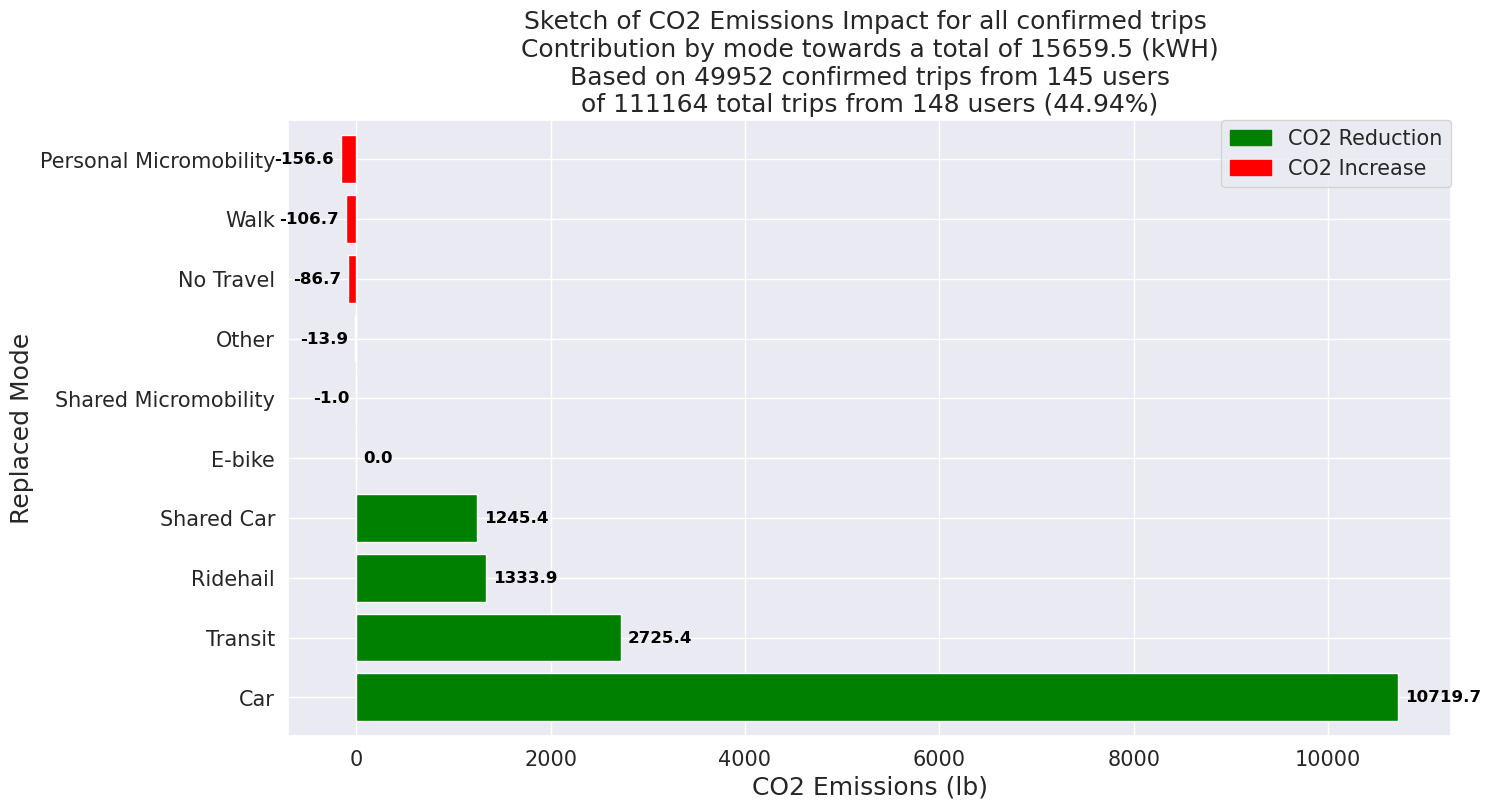

In [32]:
# Emissions
plot_data = data_eb.copy()
co2rp = plot_data.groupby('Replaced_mode').agg({'CO2_Impact(lb)': ['sum','mean']},)
co2rp.columns = ['total_lb_CO2_emissions', 'average_lb_CO2_emission']
co2rp = co2rp.reset_index()
co2rp= co2rp.sort_values(by=['total_lb_CO2_emissions'], ascending=False)
co2rp['boolean'] = co2rp['total_lb_CO2_emissions'] > 0

net_CO2_saved = round(sum(co2rp['total_lb_CO2_emissions']), 2)

x = co2rp['total_lb_CO2_emissions']
y = co2rp['Replaced_mode']
color =co2rp['boolean']

plot_title="Sketch of CO2 Emissions Impact for all confirmed trips \n Contribution by mode towards a total of %s (kWH) \n%s" % (net_CO2_saved, quality_text)
file_name ='CanBikeCO_report_sketch_all_mode_CO2impact%s' % file_suffix
CO2_impact(x,y,color,plot_title,file_name)

file_name='CanBikeCO_report_purp_share%s'%file_suffix
fig.tight_layout()
plt.show()
fig.savefig(SAVE_DIR+file_name+".png", bbox_inches='tight')

### Who Rides E-Bikes, and Why?

In [33]:
sns.set_palette('Set1', 9)

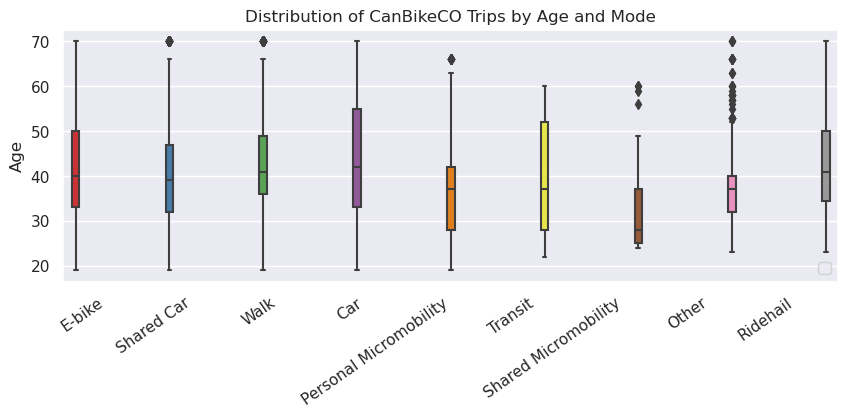

In [34]:
# Distribution of mode by age
plot_data = data.copy()

plot_title = 'Distribution of CanBikeCO Trips by Age and Mode'
ylab = 'Age'
file_name = "CanBikeCO_report_age%s"%file_suffix

fig, ax = plt.subplots(figsize=(10,4))
sns.boxplot(ax=ax, data=plot_data, x='Mode_confirm', y='AGE', hue='Mode_confirm').set(title=plot_title, xlabel='', ylabel=ylab)
plt.subplots_adjust(bottom=0.25)
plt.xticks(rotation=35, ha='right')
plt.legend([])
ax.figure.savefig(SAVE_DIR+file_name+".png", bbox_inches='tight')

In [35]:
sns.set_palette('Set2', 6)

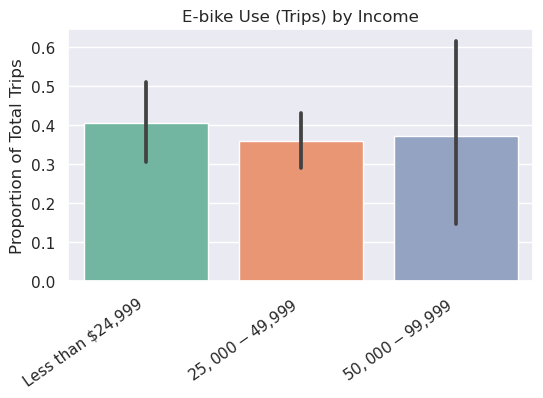

In [36]:
# Proportion of trips that are ebike by income group
plot_data = data.copy()

t1 = plot_data.groupby(['user_id','Mode_confirm'], as_index=False).count()[['user_id','Mode_confirm','distance_miles']]
t1['distance_miles'].fillna(0, inplace=True)
t2 = plot_data.groupby(['user_id'], as_index=False).count()[['user_id','distance_miles']]
plot_data = t1.merge(t2, on='user_id')
plot_data['proportion'] = plot_data['distance_miles_x'] / plot_data['distance_miles_y']
plot_data['proportion'].fillna(0, inplace=True)
t3 = data.copy().groupby(['HHINC','user_id'], as_index=False).nth(0)[['HHINC','user_id']]

plot_data = plot_data[plot_data['Mode_confirm']=='E-bike']
plot_data = plot_data.merge(t3, on='user_id')

file_name = 'CanBikeCO_report_income_trip%s'%file_suffix
ylab='Proportion of Total Trips'
plot_title = 'E-bike Use (Trips) by Income'
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=plot_data, x='HHINC', y='proportion', estimator=np.mean).set(title=plot_title,xlabel='',ylabel=ylab)
plt.xticks(rotation=35, ha='right')
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig(SAVE_DIR+file_name+".png", bbox_inches='tight')

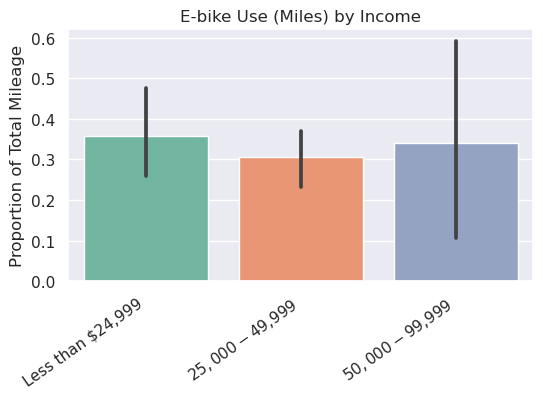

In [37]:
# Proportion of trips that are ebike by income group
plot_data = data.copy()

t1 = plot_data.groupby(['user_id','Mode_confirm'], as_index=False).sum()[['user_id','Mode_confirm','distance_miles']]
t1['distance_miles'].fillna(0, inplace=True)
t2 = plot_data.groupby(['user_id'], as_index=False).sum()[['user_id','distance_miles']]
plot_data = t1.merge(t2, on='user_id')
plot_data['proportion'] = plot_data['distance_miles_x'] / plot_data['distance_miles_y']
plot_data['proportion'].fillna(0, inplace=True)
t3 = data.copy().groupby(['HHINC','user_id'], as_index=False).nth(0)[['HHINC','user_id']]

plot_data = plot_data[plot_data['Mode_confirm']=='E-bike']
plot_data = plot_data.merge(t3, on='user_id')

file_name = 'CanBikeCO_report_income_mileage%s'%file_suffix
ylab='Proportion of Total Mileage'
plot_title = 'E-bike Use (Miles) by Income'
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=plot_data, x='HHINC', y='proportion', estimator=np.mean).set(title=plot_title,xlabel='',ylabel=ylab)
plt.xticks(rotation=35, ha='right')
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig(SAVE_DIR+file_name+".png", bbox_inches='tight')

In [38]:
sns.set_palette('Paired', 5)

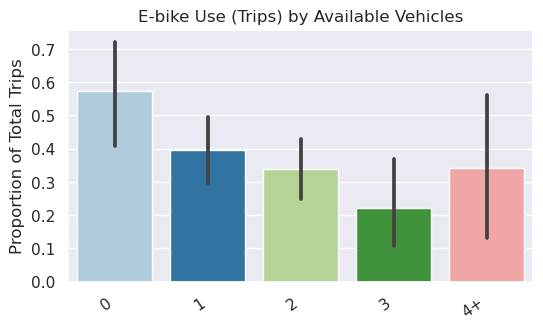

In [39]:
# Proportion of trips that are ebike by income group
plot_data = data.copy()

t1 = plot_data.groupby(['user_id','Mode_confirm'], as_index=False).count()[['user_id','Mode_confirm','distance_miles']]
t1['distance_miles'].fillna(0, inplace=True)
t2 = plot_data.groupby(['user_id'], as_index=False).count()[['user_id','distance_miles']]
plot_data = t1.merge(t2, on='user_id')
plot_data['proportion'] = plot_data['distance_miles_x'] / plot_data['distance_miles_y']
plot_data['proportion'].fillna(0, inplace=True)
t3 = data.copy().groupby(['VEH','user_id'], as_index=False).nth(0)[['VEH','user_id']]

plot_data = plot_data[plot_data['Mode_confirm']=='E-bike']
plot_data = plot_data.merge(t3, on='user_id')

file_name = 'CanBikeCO_report_veh_trip%s'%file_suffix
plot_title = 'E-bike Use (Trips) by Available Vehicles'
ylab='Proportion of Total Trips'
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=plot_data, x='VEH', y='proportion', estimator=np.mean).set(title=plot_title,xlabel='',ylabel=ylab)
plt.xticks(rotation=35, ha='right')
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig(SAVE_DIR+file_name+".png", bbox_inches='tight')

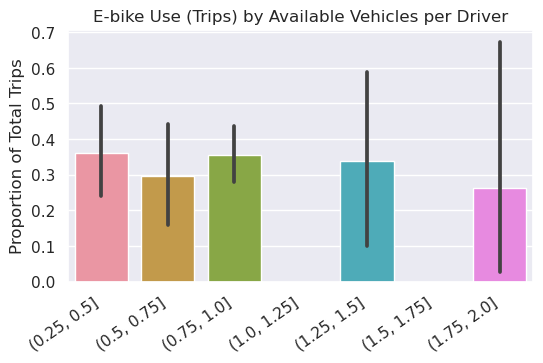

In [40]:
# Proportion of trips that are ebike by income group
plot_data = data.copy()

t1 = plot_data.groupby(['user_id','Mode_confirm'], as_index=False).count()[['user_id','Mode_confirm','distance_miles']]
t1['distance_miles'].fillna(0, inplace=True)
t2 = plot_data.groupby(['user_id'], as_index=False).count()[['user_id','distance_miles']]
plot_data = t1.merge(t2, on='user_id')
plot_data['proportion'] = plot_data['distance_miles_x'] / plot_data['distance_miles_y']
plot_data['proportion'].fillna(0, inplace=True)
t3 = data.copy().groupby(['VEH','user_id'], as_index=False).nth(0)[['veh_per_driver','user_id']]
plot_data = plot_data[plot_data['Mode_confirm']=='E-bike']
plot_data = plot_data.merge(t3, on='user_id')
plot_data['veh_per_driver'] = pd.cut(plot_data['veh_per_driver'], bins=[.25,.5,.75,1,1.25,1.5,1.75,2])

file_name = 'CanBikeCO_report_vehpdriver_trip%s'%file_suffix
plot_title = 'E-bike Use (Trips) by Available Vehicles per Driver'
ylab='Proportion of Total Trips'
fig, ax = plt.subplots(figsize=(6,4))
# sns.boxplot(ax=ax, data=plot_data, x='veh_per_driver', y='proportion').set(title=plot_title, xlabel='', ylabel=ylab)
sns.barplot(data=plot_data, x='veh_per_driver', y='proportion', estimator=np.mean).set(title=plot_title,xlabel='',ylabel=ylab)
plt.xticks(rotation=35, ha='right')
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig(SAVE_DIR+file_name+".png", bbox_inches='tight')

In [41]:
sns.set_palette('Set1', 3)

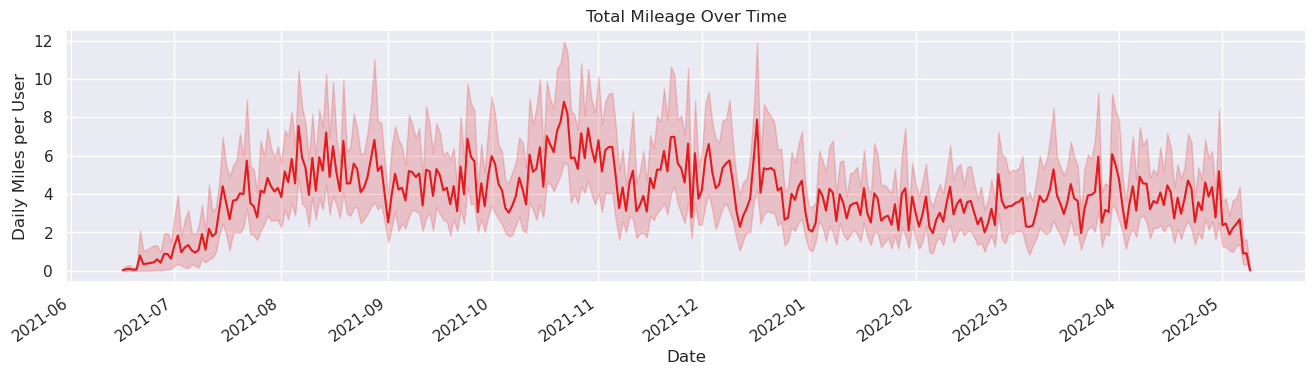

In [42]:
# How total mileage changes over time
plot_data = data.copy()

t1 = plot_data.groupby(['user_id','date_time'], as_index=False).sum()[['user_id','date_time','distance_miles']]
t1['distance_miles'].fillna(0, inplace=True)
plot_data = t1

plot_title = 'Total Mileage Over Time'
ylab = 'Daily Miles per User'
file_name = "CanBikeCO_report_ts_miles%s"%file_suffix
fig, ax = plt.subplots(figsize=(16,4))
sns.lineplot(data=plot_data, x='date_time', y='distance_miles', estimator=np.mean).set(title=plot_title, xlabel='Date', ylabel=ylab)
plt.xticks(rotation=35, ha='right')
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig(SAVE_DIR+file_name+".png", bbox_inches='tight')

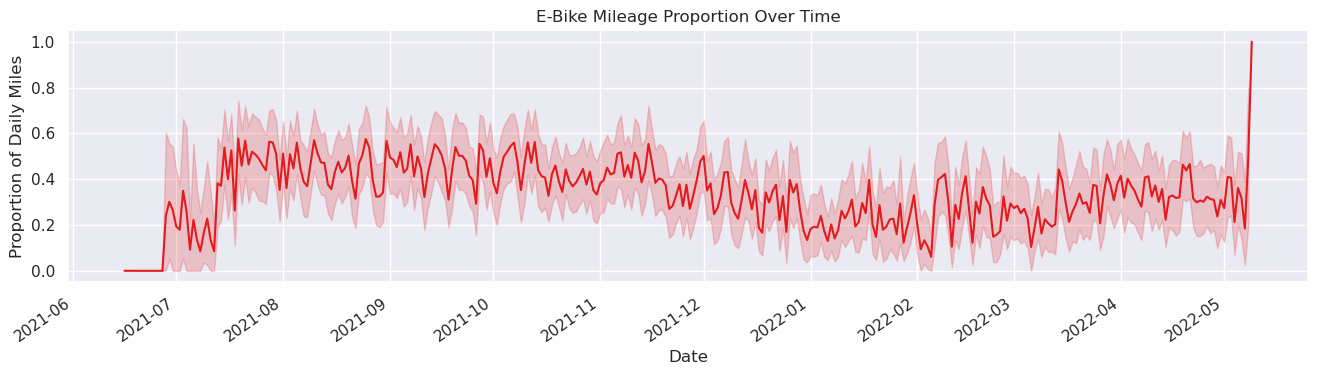

In [43]:
# How ebike mileage changes over time
plot_data = data.copy()

t1 = plot_data.groupby(['user_id','date_time','Mode_confirm'], as_index=False).sum()[['user_id','date_time','Mode_confirm','distance_miles']]
t1['distance_miles'].fillna(0, inplace=True)
t2 = plot_data.groupby(['user_id','date_time'], as_index=False).sum()[['user_id','date_time','distance_miles']]
plot_data = t1.merge(t2, on=['user_id','date_time'])
plot_data['proportion'] = plot_data['distance_miles_x'] / plot_data['distance_miles_y']
plot_data['proportion'].fillna(0, inplace=True)
plot_data = plot_data[plot_data['Mode_confirm']=='E-bike']
plot_data = plot_data[plot_data['distance_miles_y'].notnull()]

plot_title = 'E-Bike Mileage Proportion Over Time'
ylab = 'Proportion of Daily Miles'
file_name = "CanBikeCO_report_ts_mileage_proportion%s"%file_suffix
fig, ax = plt.subplots(figsize=(16,4))
sns.lineplot(data=plot_data, x='date_time', y='proportion', estimator=np.mean).set(title=plot_title, xlabel='Date', ylabel=ylab)
plt.xticks(rotation=35, ha='right')
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig(SAVE_DIR+file_name+".png", bbox_inches='tight')

In [44]:
sns.set_palette('Set1', 9)

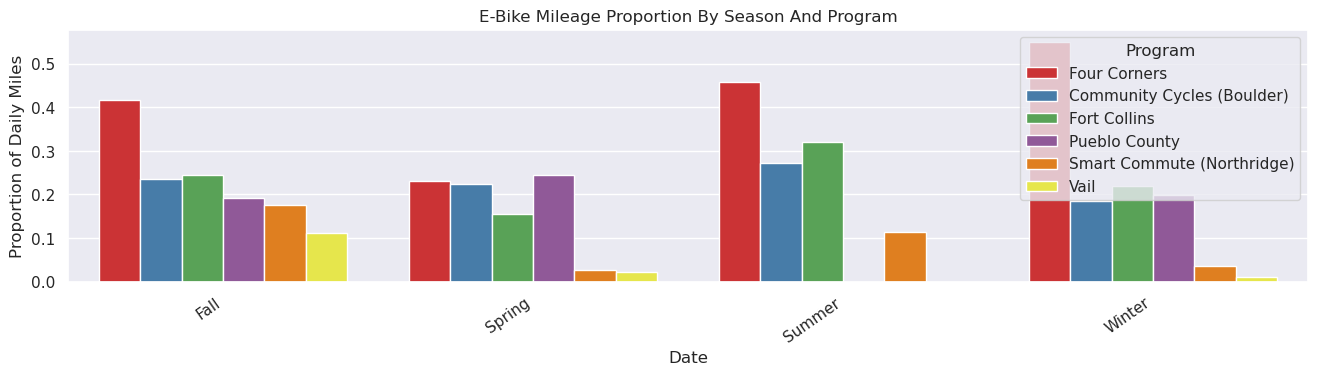

In [45]:
# How ebike mileage changes over time by program
plot_data = data.copy()

plot_data['month'] = plot_data.date_time.dt.month
plot_data['month'] = plot_data['month'].replace([6,7,8,9,10,11,12,1,2,3,4,5], ['Summer','Summer','Summer','Fall','Fall','Fall','Winter','Winter','Winter','Spring','Spring','Spring'])
t1 = plot_data.groupby(['program','month','Mode_confirm'], as_index=False).sum()[['program','month','Mode_confirm','distance_miles']]
t1['distance_miles'].fillna(0, inplace=True)
t2 = plot_data.groupby(['program','month'], as_index=False).sum()[['program','month','distance_miles']]
plot_data = t1.merge(t2, on=['program','month'])
plot_data['proportion'] = plot_data['distance_miles_x'] / plot_data['distance_miles_y']
plot_data['proportion'].fillna(0, inplace=True)
plot_data = plot_data[plot_data['Mode_confirm']=='E-bike']
plot_data['Program'] = plot_data['program'].replace(['4c','cc','fc','pc','sc','vail'],['Four Corners','Community Cycles (Boulder)','Fort Collins','Pueblo County','Smart Commute (Northridge)','Vail'])

plot_title = 'E-Bike Mileage Proportion By Season And Program'
ylab = 'Proportion of Daily Miles'
file_name = "CanBikeCO_report_ts_mileage_season%s"%file_suffix
fig, ax = plt.subplots(figsize=(16,4))
sns.barplot(data=plot_data, x='month', y='proportion', hue='Program', estimator=np.mean, ci=None).set(title=plot_title, xlabel='Date', ylabel=ylab)
plt.xticks(rotation=35, ha='right')
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig(SAVE_DIR+file_name+".png", bbox_inches='tight')

In [46]:
sns.set_palette('Set1', 9)

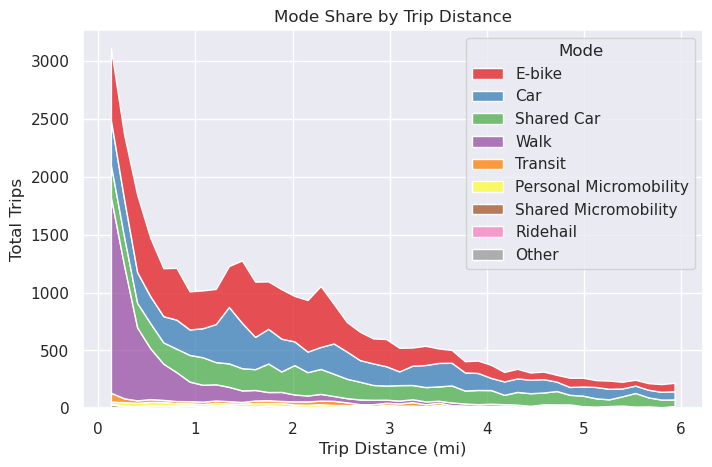

In [47]:
# Distance and mode chosen relationship
plot_data = data.copy()
plot_data = plot_data[plot_data['distance_miles']<6]

plot_title = 'Mode Share by Trip Distance'
ylab = 'Total Trips'
file_name = "CanBikeCO_report_mode_share_distance_short%s"%file_suffix
proportion_hist_plot(plot_data, 'distance_miles', plot_title, ylab, file_name)

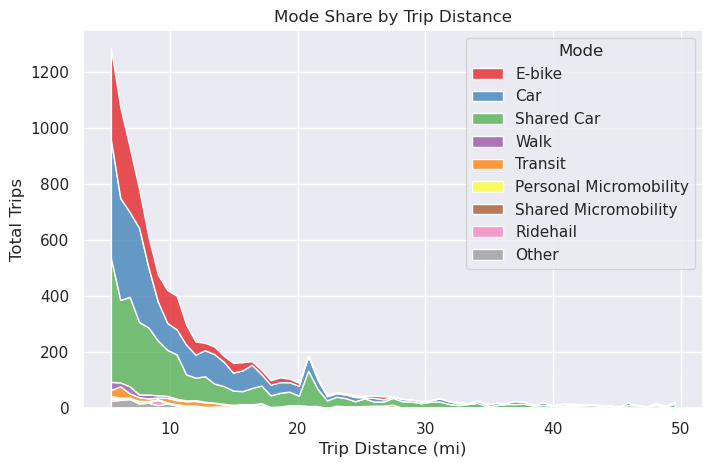

In [48]:
# Distance and mode chosen relationship
plot_data = data.copy()
plot_data = plot_data[plot_data['distance_miles']>5]

plot_title = 'Mode Share by Trip Distance'
ylab = 'Total Trips'
file_name = "CanBikeCO_report_mode_share_distance_long%s"%file_suffix
proportion_hist_plot(plot_data, 'distance_miles', plot_title, ylab, file_name)

### What Does an E-Bike Replace

In [49]:
sns.set_palette('Dark2', 10)

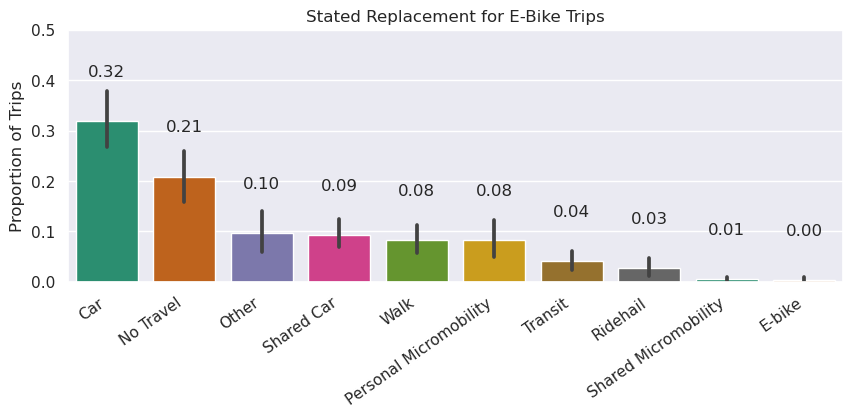

In [50]:
# Substitution rate of ebike trips
plot_data = data.copy()
t1 = plot_data.groupby(['user_id','Replaced_mode'], as_index=False).count()[['user_id','Replaced_mode','distance_miles']]
t1['distance_miles'].fillna(0, inplace=True)
t2 = plot_data.groupby(['user_id'], as_index=False).count()[['user_id','distance_miles']]
plot_data = t1.merge(t2, on='user_id')
plot_data['proportion'] = plot_data['distance_miles_x'] / plot_data['distance_miles_y']
plot_data['proportion'].fillna(0, inplace=True)

data_order = plot_data.groupby(['Replaced_mode'], as_index=False).mean().sort_values('proportion', ascending=False).Replaced_mode
labels = plot_data.groupby(['Replaced_mode'], as_index=False).mean().sort_values('proportion', ascending=False).Replaced_mode

plot_title='Stated Replacement for E-Bike Trips'
ylab='Proportion of Trips'
file_name='CanBikeCO_report_replacement%s'%file_suffix
fig, ax = plt.subplots(figsize=(10,4))
sns.barplot(data=plot_data, x='Replaced_mode', y='proportion', estimator=np.mean, order=data_order).set(title=plot_title,xlabel='',ylabel=ylab,ylim=(0,.5))
plt.xticks(rotation=35, ha='right')
plt.subplots_adjust(bottom=0.25)
ax.bar_label(ax.containers[0], fmt='%.2f', padding=30)
ax.figure.savefig(SAVE_DIR+file_name+".png", bbox_inches='tight')

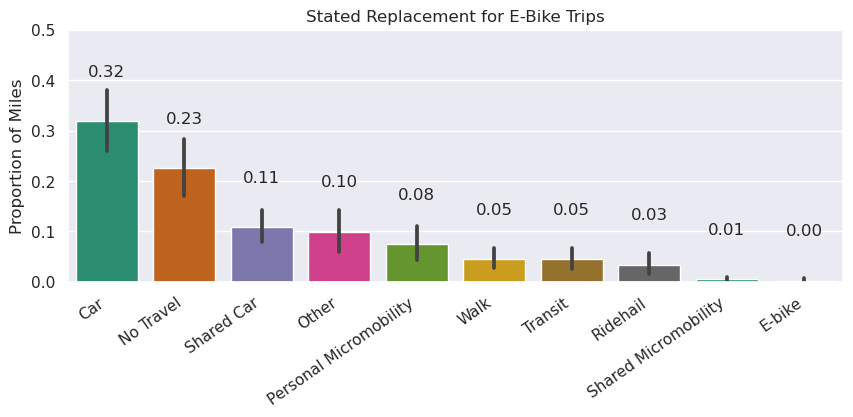

In [51]:
# Substitution rate of ebike trips
plot_data = data.copy()
t1 = plot_data.groupby(['user_id','Replaced_mode'], as_index=False).sum()[['user_id','Replaced_mode','distance_miles']]
t1['distance_miles'].fillna(0, inplace=True)
t2 = plot_data.groupby(['user_id'], as_index=False).sum()[['user_id','distance_miles']]
plot_data = t1.merge(t2, on='user_id')
plot_data['proportion'] = plot_data['distance_miles_x'] / plot_data['distance_miles_y']
plot_data['proportion'].fillna(0, inplace=True)

data_order = plot_data.groupby(['Replaced_mode'], as_index=False).mean().sort_values('proportion', ascending=False).Replaced_mode
labels = plot_data.groupby(['Replaced_mode'], as_index=False).mean().sort_values('proportion', ascending=False).Replaced_mode

plot_title='Stated Replacement for E-Bike Trips'
ylab='Proportion of Miles'
file_name='CanBikeCO_report_replacement_miles%s'%file_suffix
fig, ax = plt.subplots(figsize=(10,4))
sns.barplot(data=plot_data, x='Replaced_mode', y='proportion', estimator=np.mean, order=data_order).set(title=plot_title,xlabel='',ylabel=ylab,ylim=(0,.5))
plt.xticks(rotation=35, ha='right')
plt.subplots_adjust(bottom=0.25)
ax.bar_label(ax.containers[0], fmt='%.2f', padding=30)
ax.figure.savefig(SAVE_DIR+file_name+".png", bbox_inches='tight')

In [52]:
sns.set_palette('Paired', 2)

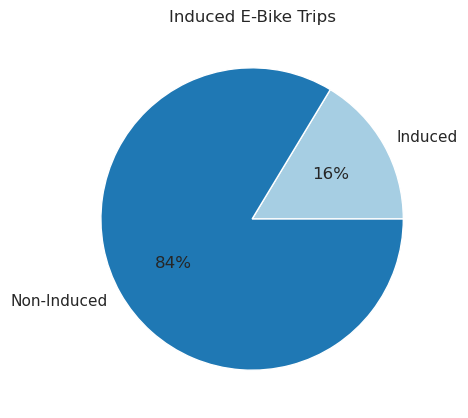

In [53]:
# E-bike trips that would not have otherwise occurred
plot_data = data_eb.copy()
plot_data['is_disc'] = 'Non-Induced'
plot_data.loc[(plot_data['Trip_purpose'] == 'Recreation/Exercise') | (plot_data['Replaced_mode'] == 'No Travel'), 'is_disc'] = 'Induced'
plot_data = plot_data.groupby(['is_disc'], as_index=False).count()[['is_disc','distance_miles']]

plot_title='Induced E-Bike Trips'
ylab='Trips'
file_name='CanBikeCO_report_discretionary%s'%file_suffix
fig, ax = plt.subplots(figsize=(6,6))
plt.pie(data=plot_data, x='distance_miles', labels=pd.unique(plot_data.is_disc), autopct='%.0f%%')
plt.subplots_adjust(bottom=0.25)
plt.title(plot_title)
ax.figure.savefig(SAVE_DIR+file_name+".png", bbox_inches='tight')

In [54]:
# Emissions analysis
z = data_eb.groupby('Replaced_mode', as_index=False).sum('distance')[['Replaced_mode','distance']]

co2_combo_factors = [5170*157.2*.000001,
                    .022*1166*.001,
                    0,
                    0,
                    0,
                    7214*157.2*.000001,
                    2585*157.2*.000001,
                    .027*1166*.001,
                    4560*161.3*.000001,
                    0]
co2_ebike_factor = .022*1166*.001
z['co2_impact_factor'] = [x-co2_ebike_factor for x in co2_combo_factors]
z['lb_co2'] = z['distance']*z['co2_impact_factor'] # Reduction=positive
metric_ton_co2_reduction = sum(z['lb_co2'])/2204
unique_users = len(pd.unique(data_eb['user_id']))
print(f"Net reduction: {metric_ton_co2_reduction} metric tons over {unique_users} users.")
print(f"Net program costs: {2400*unique_users}")
print(f"Program $/mtCO2: {(2400*unique_users) / (metric_ton_co2_reduction)}")

Net reduction: 11467.884763195669 metric tons over 114 users.
Net program costs: 273600
Program $/mtCO2: 23.857930703844808


In [55]:
# Income analysis
mean_hhinc = np.mean(data.groupby('user_id', as_index=False).min('HHINC_NUM')[['user_id','HHINC_NUM']].HHINC_NUM.dropna())
mean_hourly_wage = mean_hhinc / 52 / 40
9.70 / 16

0.60625